In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pranaykoppula/torgo-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/torgo-audio


In [4]:
# Make a clean target
!mkdir -p /content/torgo-audio

# Copy everything over
!cp -r "/kaggle/input/torgo-audio" /content/

In [5]:
!pip install ai-edge-torch-nightly torchvision  # :contentReference[oaicite:0]{index=0}


In [6]:
# Cell 1: Imports
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.models import mobilenet_v3_small


In [7]:
# Cell 2: Config & Globals
base_path = "/content/torgo-audio"
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# These will be filled in later
audio_files = []
labels      = []
X_mfcc      = None
y_labels    = None

# Global model variable
classifier: nn.Module = None
conf_matrix  = None
class_report = None


In [8]:
# Cell 3: Data loading + feature extraction
def load_audio_files(base_path):
    audio_files, labels = [], []
    subdirs = ['F_Con', 'F_Dys', 'M_Con', 'M_Dys']
    for subdir in tqdm(subdirs, desc="Processing Directories"):
        path = os.path.join(base_path, subdir)
        label = 'Dysarthric' if 'Dys' in subdir else 'Control'
        for root, _, files in os.walk(path):
            for f in files:
                if f.endswith('.wav'):
                    audio_files.append(os.path.join(root, f))
                    labels.append(label)
    return audio_files, labels

def extract_mfcc(file_path, duration=3, sr=16000, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f"Error {file_path}: {e}")
        return None

def prepare_feature_vectors(audio_files, labels):
    feats, labs = [], []
    le = LabelEncoder()
    enc = le.fit_transform(labels)
    for fp, lb in tqdm(zip(audio_files, enc), total=len(audio_files), desc="Extracting MFCC"):
        mf = extract_mfcc(fp)
        if mf is not None:
            feats.append(mf)
            labs.append(lb)
    if not feats:
        raise RuntimeError("No features extracted!")
    X = torch.tensor(feats, dtype=torch.float32)
    y = torch.tensor(labs)
    return X, y


In [9]:
# Cell 4: Model definition + instantiate global classifier
class MobileNetV3Classifier(nn.Module):
    def __init__(self, input_dim=40, output_dim=2):
        super().__init__()
        self.prep = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Unflatten(1, (1, 1, 128))
        )
        self.repeat = nn.Conv2d(1, 3, kernel_size=1)
        self.net = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.net.classifier[3] = nn.Linear(
            self.net.classifier[3].in_features,
            output_dim
        )

    def forward(self, x):
        x = self.prep(x)
        x = torch.nn.functional.interpolate(x, size=(128, 128), mode='bilinear')
        x = self.repeat(x)
        return self.net(x)

# instantiate
classifier = MobileNetV3Classifier().to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 183MB/s]


In [10]:
# Cell 5: Training function (in‑place on global `classifier`)
def train_model(X, y, test_size=0.2, random_state=42, epochs=50):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=32, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_te, y_te), batch_size=32, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

    for _ in tqdm(range(epochs), desc="Training"):
        classifier.train()
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            loss = criterion(classifier(bx), by)
            loss.backward()
            optimizer.step()

    # evaluation
    classifier.eval()
    preds, trues = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            bx, by = bx.to(device), by.to(device)
            out = classifier(bx)
            _, p = out.max(1)
            preds.extend(p.cpu().numpy())
            trues.extend(by.cpu().numpy())

    global conf_matrix, class_report
    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(trues, preds, target_names=class_names)
    conf_matrix  = confusion_matrix(trues, preds)


In [11]:
# Cell 6: Plotting helper
def plot_confusion(conf_matrix, class_names=['Control','Dysarthric']):
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Processing Directories: 100%|██████████| 4/4 [00:00<00:00, 40.90it/s]


17635 files found


Extracting MFCC:  15%|█▌        | 2675/17635 [00:35<01:54, 131.04it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting MFCC:  27%|██▋       | 4685/17635 [00:55<01:27, 148.53it/s]/tmp/ipython-input-8-2404025505.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC:  27%|██▋       | 4700/17635 [00:55<01:27, 147.83it/s]

Error /content/torgo-audio/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC:  27%|██▋       | 4783/17635 [00:55<01:21, 158.52it/s]

Error /content/torgo-audio/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 


Extracting MFCC:  94%|█████████▎| 16509/17635 [02:29<00:08, 136.66it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1206
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(
Extracting MFCC:  94%|█████████▎| 16524/17635 [02:30<00:08, 137.81it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=667
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=137
  warnings.warn(
Extracting MFCC:  94%|█████████▍| 16538/17635 [02:30<00:07, 137.25it/s]/usr/local/

Feature shape: torch.Size([17633, 40])


Training: 100%|██████████| 50/50 [08:33<00:00, 10.27s/it]


              precision    recall  f1-score   support

     Control       0.98      0.99      0.98      2291
  Dysarthric       0.97      0.96      0.97      1236

    accuracy                           0.98      3527
   macro avg       0.98      0.97      0.98      3527
weighted avg       0.98      0.98      0.98      3527



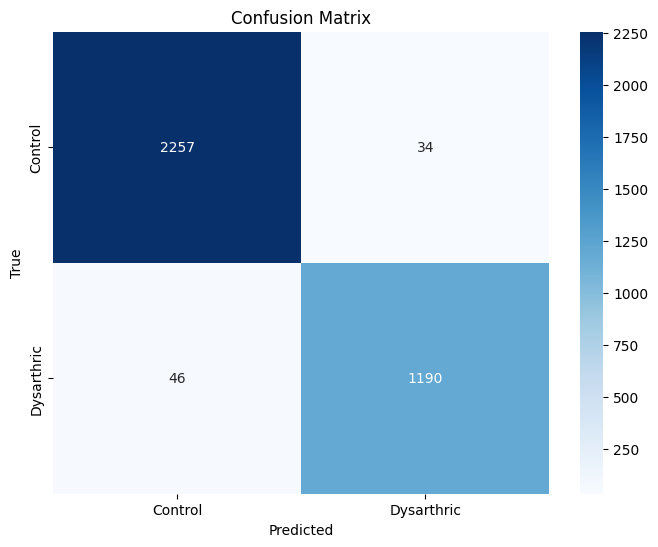

In [12]:
# Cell 7: Run everything
# 1) load
audio_files, labels = load_audio_files(base_path)
print(f"{len(audio_files)} files found")
# 2) featurize
X_mfcc, y_labels = prepare_feature_vectors(audio_files, labels)
print("Feature shape:", X_mfcc.shape)
# 3) train
train_model(X_mfcc, y_labels)
print(class_report)
plot_confusion(conf_matrix)


In [13]:
# Cell 8: (Stub) save/download & convert to TFLite
# After training, `classifier` holds your trained model.

# 1) Save weights
torch.save(classifier.state_dict(), "classifier.pth")

# 2) (Optional) Download from remote:
# !wget -O classifier.pth https://.../classifier.pth

# 3) Load + trace
# classifier = MobileNetV3Classifier().to(device)
# classifier.load_state_dict(torch.load("classifier.pth"))
# classifier.eval()
# example = torch.randn(1,40).to(device)
# traced = torch.jit.trace(classifier, example)
# traced.save("model_scripted.pt")

# 4) You can now convert model_scripted.pt → TFLite using the standard tflite_convert workflow.


In [16]:
! pip uninstall -y tf-nightly tf tensorflow


Found existing installation: tf_nightly 2.20.0.dev20250515
Uninstalling tf_nightly-2.20.0.dev20250515:
  Successfully uninstalled tf_nightly-2.20.0.dev20250515
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [17]:
! pip install tf-nightly==2.20.0.dev20250515


  Using cached tf_nightly-2.20.0.dev20250515-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached tf_nightly-2.20.0.dev20250515-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.9 MB)


In [18]:
! pip install ai-edge-torch torchvision

In [19]:
import ai_edge_torch  # should load without that NotFoundError


/usr/local/lib/python3.11/dist-packages/torch/distributed/distributed_c10d.py:354: UserWarning: Device capability of jax unspecified, assuming `cpu` and `cuda`. Please specify it via the `devices` argument of `register_backend`.
  warnings.warn(


In [20]:

import numpy as np
import torch

# Move model to CPU and set to eval
classifier_cpu = classifier.eval().cpu()

# Create a sample input matching our model's signature
sample_inputs = (torch.randn(1, 40),)

# Convert to LiteRT/TFLite format :contentReference[oaicite:0]{index=0}
edge_model = ai_edge_torch.convert(classifier_cpu, sample_inputs)

# (Optional) Validate the converted model yields the same outputs
torch_out = classifier_cpu(*sample_inputs).detach().numpy()
edge_out  = edge_model(*sample_inputs)
if np.allclose(torch_out, edge_out, atol=1e-5, rtol=1e-5):
    print("Conversion validated")
else:
    print("Warning: Outputs differ")

# Export as a .tflite flatbuffer :contentReference[oaicite:1]{index=1}
edge_model.export("classifier.tflite")


Conversion validated


FileNotFoundError: [Errno 2] No such file or directory: ''

In [21]:
import os
os.makedirs("exported_models", exist_ok=True)
edge_model.export("exported_models/classifier.tflite")

In [22]:
# Cell X: Load TFLite model and randomly sample WAVs for inference
import random
import numpy as np
import librosa
from tensorflow.lite.python.interpreter import Interpreter

# Configuration
base_path = "/content/torgo-audio"        # Root of TORGO dataset
num_samples = 5                            # How many WAV files to sample

# 1) Gather all audio file paths
# Assumes load_audio_files has been defined in a previous cell
audio_files, _ = load_audio_files(base_path)

# 2) Randomly sample files
sampled_wavs = random.sample(audio_files, num_samples)
print("Randomly sampled WAV files:")
for wav in sampled_wavs:
    print(wav)

# 3) Load the TFLite model
interpreter = Interpreter(model_path="exported_models/classifier.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 4) MFCC extraction helper
def extract_mfcc_np(file_path, duration=3, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr, duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0).astype(np.float32)

# 5) Run inference on each sample
class_names = ['Control', 'Dysarthric']
for wav in sampled_wavs:
    mfcc_vec = extract_mfcc_np(wav)           # (40,)
    input_data = mfcc_vec.reshape(1, 40)      # (1, 40)

    # Ensure dtype matches model's input
    if input_data.dtype != input_details[0]['dtype']:
        input_data = input_data.astype(input_details[0]['dtype'])

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])  # (1, 2)
    pred = int(np.argmax(output_data, axis=1)[0])

    print(f"\nFile: {wav}")
    print(f"Prediction: {class_names[pred]}, scores={output_data[0]}")



Processing Directories: 100%|██████████| 4/4 [00:00<00:00, 24.65it/s]
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Randomly sampled WAV files:
/content/torgo-audio/M_Dys/wav_headMic_M01S01/wav_headMic_M01S01_0065.wav
/content/torgo-audio/F_Dys/wav_arrayMic_F04S01/wav_arrayMic_F04S01_0158.wav
/content/torgo-audio/M_Con/wav_headMic_MC04S01/wav_headMic_MC04S01_0078.wav
/content/torgo-audio/F_Con/wav_headMic_FC02S03/wav_headMic_FC02S03_0919.wav
/content/torgo-audio/M_Con/wav_arrayMic_MC04S01/wav_arrayMic_MC04S01_0458.wav

File: /content/torgo-audio/M_Dys/wav_headMic_M01S01/wav_headMic_M01S01_0065.wav
Prediction: Dysarthric, scores=[-5.3847055  4.9036913]

File: /content/torgo-audio/F_Dys/wav_arrayMic_F04S01/wav_arrayMic_F04S01_0158.wav
Prediction: Dysarthric, scores=[-5.620904  5.195125]

File: /content/torgo-audio/M_Con/wav_headMic_MC04S01/wav_headMic_MC04S01_0078.wav
Prediction: Control, scores=[11.696318 -9.589547]

File: /content/torgo-audio/F_Con/wav_headMic_FC02S03/wav_headMic_FC02S03_0919.wav
Prediction: Control, scores=[ 13.453866 -10.815311]

File: /content/torgo-audio/M_Con/wav_arrayMic_MC04S